In [65]:
import numpy as np
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import matplotlib.pyplot as plt

mol = pyscf.gto.M(atom='N 0 0 0.; N 0 0 1.', basis='6-31G', verbose=3)
deltaZ = np.array((0.0,0.05))
includeonly = [0, 1]

calc = pyscf.scf.RHF(mol)

mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()/(1 / 0.52917721067), deltaZ)  
class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
                return (7+deltaZ[0])*(7+deltaZ[1])/(1/0.52917721067)
mf = NoSelfQMMM()
hfe=mf.kernel(verbose=4)
mycc = pyscf.cc.CCSD(mf).run()
print ('Energy:', mycc.energy() + hfe)

dm1 = mycc.make_rdm1()
dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff, dm1, mf.mo_coeff.conj())
dm1_ao=mf.make_rdm1()
for site in includeonly:
    # method A
    #q = mol._atm.copy()
    #q[site, 0] = 0
    #a = pyscf.gto.getints('int1e_nuc_sph', q, mol._bas, mol._env)
    #print ('EPN, method A', np.matmul(a, dm1_ao).trace() / mol.atom_charges()[site])
    # method B
    mol.set_rinv_orig_(mol.atom_coords()[site])
    print ('EPN, method B', np.matmul( dm1_ao,mol.intor('int1e_rinv')).trace())


converged SCF energy = -109.750239009996
E(CCSD) = -109.9577309332241  E_corr = -0.2074919232279455
Energy: -109.95773093322414
EPN, method B 21.96999732964793
EPN, method B 22.03756637641772


In [71]:
mf.scf()
### the problem is that the unrelaxed density matrix in ccsd is the same as 
##  Hartree Fock density matrix ( a part from a small numerical error)
print(mf.make_rdm1()-dm1_ao) 

converged SCF energy = -109.750239009996
[[ 3.55271368e-15 -4.46864767e-15  7.16648962e-14 -1.63189135e-16
   6.33820378e-17  5.27355937e-16 -7.99033084e-17 -4.54553395e-18
   3.20993232e-14  7.21644966e-16  5.16947596e-15 -7.04158953e-14
   3.85624698e-17 -1.64815668e-17 -9.15933995e-16  6.62210578e-17
  -2.08567254e-17  3.40092537e-14]
 [-4.46864767e-15  1.39332990e-14 -9.25926003e-14  2.90354765e-16
  -3.39343390e-17 -1.05263021e-14  9.81008285e-17  2.09316361e-17
  -5.19029264e-14 -2.35922393e-16 -1.25524591e-14  1.00447428e-13
  -2.09455819e-16  1.18203674e-16  1.49880108e-15 -2.05948784e-16
   8.78867908e-17 -5.16531262e-14]
 [ 7.16648962e-14 -9.25926003e-14 -3.71924713e-13  4.48653581e-15
  -1.25326786e-15  7.20534743e-14  2.10600401e-15 -3.83017677e-16
  -6.84730050e-14 -2.56045185e-14  5.23747712e-14  3.08197912e-13
   3.30059881e-15 -7.41146298e-16  4.11511103e-14  1.33959318e-15
  -2.81690204e-16 -9.32171007e-14]
 [-1.63189135e-16  2.90354765e-16  4.48653581e-15  9.10382880e

0.18389847553248018

In [70]:
np.einsum('ij,ji',mycc.make_rdm1(),np.eye(18))

14.000000000000004

array([[ 0.00000000e+00,  1.38777878e-17,  1.38777878e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.77626358e-21, -3.46944695e-18,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.93889390e-18,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.77555756e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.55111512e-17,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.55111512e-17],
       [-1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.55111512e-17,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.11022302e

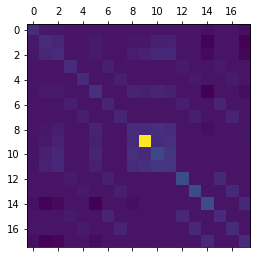

In [40]:
plt.matshow(mol.intor('int1e_rinv'))
mol.intor('int1e_rinv')-mol.intor('int1e_rinv').T

In [32]:
help(mol.set_rinv_orig_)

Help on method set_rinv_origin in module pyscf.gto.mole:

set_rinv_origin(coord) method of pyscf.gto.mole.Mole instance
    Update origin for operator :math:`\frac{1}{|r-R_O|}`.
    **Note** the unit is Bohr
    
    Examples:
    
    >>> mol.set_rinv_origin(0)
    >>> mol.set_rinv_origin((0,1,0))



In [28]:
mol.atom_coords()/(1 / 0.52917721067)

array([[0., 0., 0.],
       [0., 0., 1.]])

array([2.08510789, 0.50211401, 1.05217241, 0.42821792, 0.41463665,
       0.6641638 , 0.11165596, 0.17542803, 0.07905939, 2.08510789,
       0.50211401, 1.05217241, 0.42821792, 0.41463665, 0.6641638 ,
       0.11165596, 0.17542803, 0.07905939])

array([1.99993837, 1.99994299, 1.98899603, 1.97588856, 1.9476586 ,
       1.9476586 , 1.98092735, 0.04386803, 0.04386803, 0.00602777,
       0.00400162, 0.0059458 , 0.0059458 , 0.01215502, 0.00940992,
       0.00940992, 0.01007105, 0.00828655])

In [48]:
mol.intor('int1e_rinv')

array([[ 5.29177211e-01,  1.17591325e-01,  9.09491487e-02,
         0.00000000e+00,  0.00000000e+00,  2.30300834e-02,
         0.00000000e+00,  0.00000000e+00,  3.37425082e-03,
         5.75757734e-05,  2.32692260e-02,  4.51926896e-02,
         0.00000000e+00,  0.00000000e+00, -4.43854682e-02,
         0.00000000e+00,  0.00000000e+00, -7.43013701e-02],
       [ 1.17591325e-01,  5.28554613e-01,  4.06756179e-01,
         0.00000000e+00,  0.00000000e+00,  1.59269386e-01,
         0.00000000e+00,  0.00000000e+00,  1.01031049e-01,
         1.25363842e-01,  2.60412985e-01,  2.84327331e-01,
         0.00000000e+00,  0.00000000e+00, -2.99326727e-01,
         0.00000000e+00,  0.00000000e+00, -3.06615213e-01],
       [ 9.09491487e-02,  4.06756179e-01,  4.85888913e-01,
         0.00000000e+00,  0.00000000e+00,  1.48099628e-01,
         0.00000000e+00,  0.00000000e+00,  1.86327523e-01,
         2.82410294e-01,  4.12498415e-01,  4.46315998e-01,
         0.00000000e+00,  0.00000000e+00, -1.94712635e